Riportiamo il codice per la visualizzazione del grafico utilizzato nel norebbok precedente

In [40]:
from graphviz import Digraph

# Helper function che serve per ottenere tutti gli edge e i node presenti nel graph partendo dal nodo di root
def trace(root):
    
    # inizializza i set vuoti
    nodes, edges = set(), set()
    
    # Funzione ricorsiva che, dato un nodo, ne estre i children e li aggiunge ai set di Edge e Node
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
                
    # Chiamata iniziale alla funzione ricorsiva
    build(root)
    return nodes, edges

# Funzione che richiama l'API di Graphviz per disegnare il grafo con i nodi e gli edge che compongono la funzione
#
def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    
    # Chiamo Helper Function per estrarre gli edge e i node
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
#        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
#        dot.node(name=str(id(n)), label = "{ data %.4f }" % (n.data), shape='record')
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

Per calcolare backprop è necessario partire dal risultato finale dell'espressione e calcolare il gradient per tutti i valori intermedi. Andremo quindi a calcolare la derivata di ciascuno dei valori rispetto al valore finale. <br>
Quindi andremo a calcolare la derivata di L rispetto ad L, la derivata di L rispetto a d, rispetto a f e così via.<br>

In un NN, L rappresenterà la loss function e i valori intermedi per i quali andremo a calcolare la derivata rispetto alla Loss Function, rappresenteranno i weights. Ovviamente in un NN non saremo interessati alla derivata degli input iniziali in quanto gli stessi sono fissi. L'obiettivo è capire come andare a modificare, in modo iterativo, i weights del NN per fare in modo di minimizzare il valore della Loss Function

Andremo quindi a modificare la classe Value iniziale per aggiungere una nuova variabile "grad" che consenta di memorizzare la derivata di "L" rispetto a quel dato valore. Questo valore verrà anche visualizzato nel graph

In [41]:
class Value:
    
    # Costruttore
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        
        self.grad = 0.0    # Inizializzato a 0
        
        self._prev = set(_children) # viene tenuto il set per ragioni di efficienza
        self._op = _op
        self.label = label
        
    # Metodo utilizzato da Python per la visualizzazione dell'oggetto. Consente di impostare un visualizzazione user friendly
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Definisce l'operatore per la somma (+). Quando trova l'operatore +, Python chiama questo metodo
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    # Definisce l'operatore per la prodottp (*). Quando trova l'operatore *, Python chiama questo metodo
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

Riprendiamo la nostra espressione iniziale e procediamo con il calcolo

In [42]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d * f; L.label='L'
L

Value(data=-8.0)

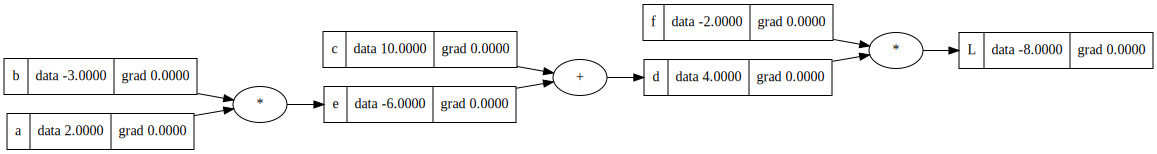

In [43]:
draw_dot(L)

Per calcolare questi gradient andremo inizialmente a calcolarli manualmente iniziando dalla derivata di L rispetto a L stesso. 

Per far ciò definiamo una funzione che ci consenta di operare su variabili locali senza "sporcare" le variabili dell'espressione già definite in global scope.
Procedendo con il concetto di derivata come limite
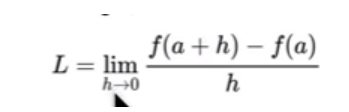

definiamo una variabile "h" molto piccola che utilizziamo per capire come influisce su ciascuno dei valori che compongono l'espressione rispetto al risultato finale

Come primo step proviamo a calcolare la derivata di L rispetto ad L calcolando la differenza tra (L +h) e L e dividendo per h

In [44]:
def lol():
    
    h = 0.001   # definisco h molto piccolo
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data
    
    a = Value(2.0, label='a') 
    b = Value(-3.0, label='b')
    c = Value(10, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data + h              # Incremento L2 col valore di h
    
    print((L2 - L1)/h)  # Stampo Rise over Run
    
lol()

1.000000000000334


Settiamo quindi manualmente la derivata di L rispetto ad L a 1

In [46]:
L.grad = 1

E visualizziamo il grafico con la valorizzazione di questa derivata

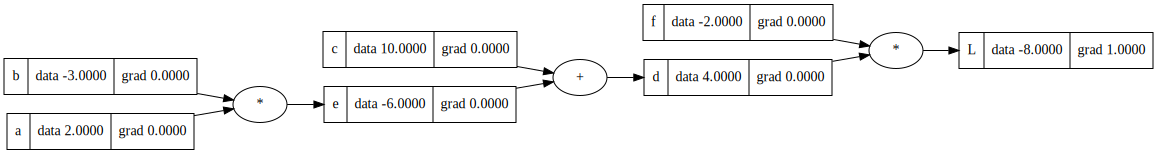

In [47]:
draw_dot(L)

A questo punto possiamo continuare ad effettuare la backprop manualmente andando a calcolare tutte le derivate dei valori intermedi. 

Ridefiniamo ogni volta la funzione lol() andando ogni volta ad incrementare una variabile diversa in modo da calcolarne l'impatto sull'output finale. 

Ad esempio, per calcolare la derivata di d rispetto ad L 

L = d * f
dL/dd

Potremmo utilizzare le regole di calculus e in tal modo otteniamo che la derivata di "d * f" rispetto a "d" è uguale a "f":

(f(x+h) -f(x))/h
((d+h)*f -d*f)/h
(d*f +h*f -d*f)/h
h*f/h
f

Stesso discorso per la derivata di f rispetto ad L 
L = d * f
dL/df

che è uguale a "d"

Quindi, settandoli manualmente

In [55]:
d.grad = -2.0
f.grad = 4.0

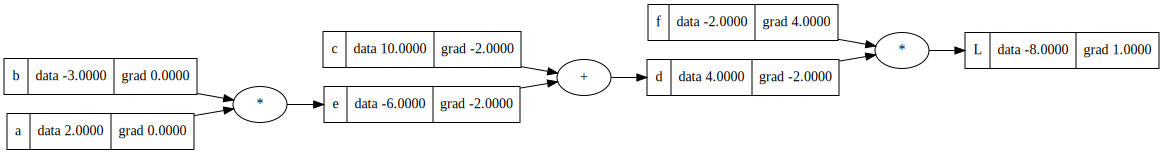

In [56]:
draw_dot(L)

Come conferma proviamo ad aggiungere h a f in modo da vedere se la derivata corrisponde a 4

In [57]:
def lol():
    
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d' 
    f = Value(-2.0 +h, label='f')  ### Incremento f di h
    L = d * f; L.label='L'
    L2 = L.data 
    
    print((L2 - L1)/h)  # Stampo Rise over Run
    
lol()

3.9999999999995595


Stesso discorso per verificare che la derivata di d rispetto a L sia -2

In [58]:
def lol():
    
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d' 
    d.data += h            ### Incremento d di h
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data 
    
    print((L2 - L1)/h)  # Stampo Rise over Run
    
lol()

-1.9999999999953388


Procedendo nella backprop andiamo a calcolare la derivata di "L" rispetto a "c" (successivamente calcoleremo la derivata di L rispetto a "e")
dL/dc

Come primo step dovremo calcolare la derivata di "c" rispetto a "d"
dd/dc

Sappiamo che 
d = c + e

quindi
(f(x+h) -f(x))/h
((c + h + e) - (c + e)) / h
h/h
1
Quindi dd/dc= 1

Di conseguenza, per simmetria, anche
dd/de= 1

Da ciò si deduce che la "local" derivative di una somma è sempre 1

Una volta trovata la local derivative, dovremo utilizzarla per calcolare la derivata finale: per far questo si utilizza la chain rule. Quindi:
dL/dc  è quello che vogliamo ottenere

Sapendo che
dL/dd = -2.0
dd/dc = 1.0

Per la chain rule 
dL/d = (dL/dd) * (dd/dc) = -2.0 * 1.0 = -2.0

In pratica la somma fa passare lo stesso gradient: distribuisce il gradient ai children nodes

Lo stesso ragionamento si applica per<br>
dL/de <br>
che, per lo stesso motivo, è sempre uguale a -2.0

In [54]:
c.grad = -2.0
e.grad = -2.0

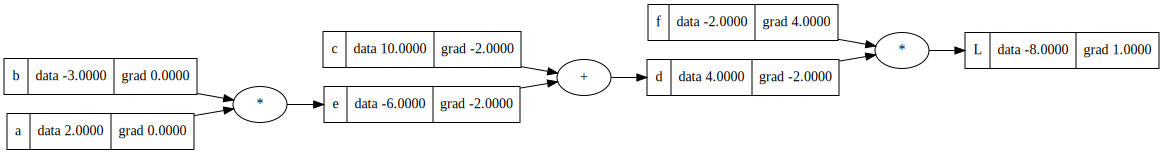

In [59]:
draw_dot(L)

Verifichiamo se è vero calcolandono numericamente per c 

In [60]:
def lol():
    
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10 +h, label='c') ### Incremento c di h
    e = a*b; e.label='e'
    d = e + c; d.label='d' 
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data 
    
    print((L2 - L1)/h)  # Stampo Rise over Run
    
lol()

-1.9999999999953388


e per "e"

In [63]:
def lol():
    
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label='c') 
    e = a*b; e.label='e'
    e.data += h            ### Incremento e di h
    d = e + c; d.label='d' 
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data 
    
    print((L2 - L1)/h)  # Stampo Rise over Run
    
lol()

-1.9999999999953388


Procedendo con la backprop, andiamo a calcolare le derivate di L rispetto a "a" e "b". Anche in questo caso dovremo applicare la chain rule.
Dobbiamo quindi trovare
dL/da (e dL/db)
Sappendo che dL/de = -2.0, per poter applicare la chain rule dovremo trovare la "local derivative" di
de/da (e quindi di dL/db)
Per la chain rule infatti:
dL/da = dL/de * de/da

Per calcolare la local derivative (de/da), sappiamo che 
e = a * b
quindi come già visto per il nodo iniziale, a fronte di una moltiplicazione,
la derivata di "e" (che è uguale a "a * b") rispetto a "a" è uguale a "b" e, viceversa la derivata di "e" rispetto a "b" è "a"
In questo modo otteniamo la local derivative.
Per calcolare la derivata 
dL/da = dL/de * de/da
applichiamo la chain rule e
dL/da = -2.0 * -3.00  (-> local derivative di e rispetto a b) = 6.00
dL/db = -2.0 * 2.00  (-> local derivative di e rispetto a a) =  -4.00

In [64]:
a.grad = 6.00
b.grad = -4.00

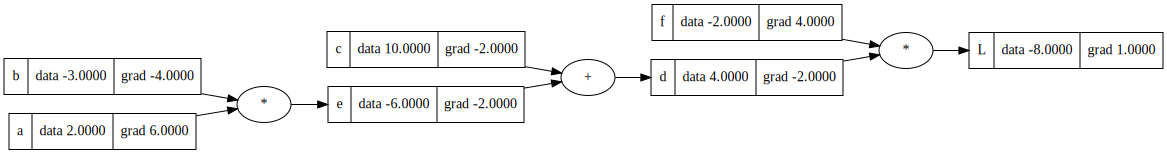

In [65]:
draw_dot(L)

Per verificare la correttezza per a

In [69]:
def lol():
    
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data
    
    a = Value(2.0 + h, label='a')     ### Incremento a di h
    b = Value(-3.0, label='b')
    c = Value(10, label='c') 
    e = a*b; e.label='e'
    d = e + c; d.label='d' 
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data 
    
    print((L2 - L1)/h)  # Stampo Rise over Run

lol()

6.000000000021544


Verifichiamo per "b"

In [71]:
def lol():
    
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data
    
    a = Value(2.0, label='a')    
    b = Value(-3.0 + h, label='b')  ### Incremento b di h
    c = Value(10, label='c') 
    e = a*b; e.label='e'
    d = e + c; d.label='d' 
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data 
    
    print((L2 - L1)/h)  # Stampo Rise over Run

lol()

-4.000000000008441


Quella che abbiamo fatto è la backprop "manuale", applicando ricorsivamente la chain rule

Vediamo come modificare i nostri input per fare in modo di aumentare il valore finale di L.

Per far ciò aggiungiamo un valore positivo nella direzione del gradient. Operando solo sui valori di cui abbiamo controllo diretto, il valore finale dell'espressione dovrebbe aumentare


In [72]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * b.grad
f.data += 0.01 * f.grad

Rieseguiamo il forward pass coi nuovi valori

In [73]:
e = a*b
d = e + c
L = d * f
L

Value(data=-7.247296)